In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34259")
client

<Client: 'tcp://127.0.0.1:34259' processes=8 threads=40, memory=168.99 GB>

In [2]:
import numpy as np
import xarray as xr
import gsw
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import dask_image.ndfilters as dsfilt
import scipy.sparse as spar
import dask.array as dsar
from xhistogram.xarray import histogram as xhist
import xrft
import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.ticker as mtick
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [4]:
year = 2008

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 15
yend = 50
nremap = 50
nsig = 25

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
itime = 7886160
dsbathy = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,year)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=itime,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,year)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=itime,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(ySstart-12**-1,yend+2*12**-1),
                          YG=slice(ySstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 783, YG: 783, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float64 1.577e+09
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG       (YG) >f4 -15.041634 -14.9583 -14.874967 ... 50.041702 50.125034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1      (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu       (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl       (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxG      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAz      (YG, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    drC      (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefF   (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

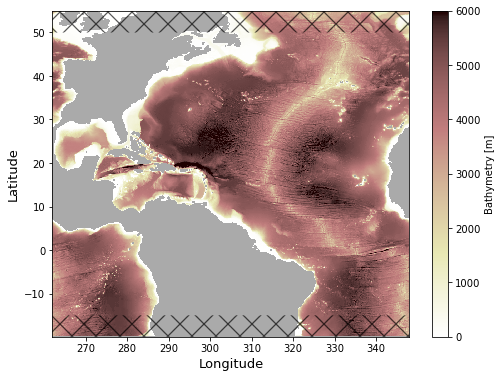

In [43]:
fig, ax = plt.subplots(figsize=(8,6))

im = ax.pcolormesh(dsbathy.XC, dsbathy.YC, dsbathy.Depth.where(dsbathy.maskInC!=0.), 
                   cmap='pink_r', rasterized=True, vmin=0, vmax=6e3)
ax.pcolormesh(dsbathy.XC, dsbathy.YC, dsbathy.maskInC.where(dsbathy.maskInC==0.),
              vmin=-2, vmax=1, cmap='binary_r', rasterized=True)

ax.pcolor(dsbathy.XC, dsbathy.YC, dsbathy.Depth.where(dsbathy.YC>50), 
          hatch='X', alpha=0., rasterized=True)
ax.pcolor(dsbathy.XC, dsbathy.YC, dsbathy.Depth.where(dsbathy.YC<-15), 
          hatch='X', alpha=0., rasterized=True)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"Bathymetry [m]")
ax.set_xlabel('Longitude', fontsize=13)
ax.set_ylabel('Latitude', fontsize=13)
plt.savefig(op.join(ddir,'Figures/Bathymetry.pdf'))

In [6]:
nremap = 140

dsz = xr.open_zarr(op.join(ddir,'5Dave/run%4d/Zs/%010d' % (year,itime))
                  )
dsmn = xr.open_zarr(op.join(ddir,'5Dave/run%4d/Dyns/%010d' % (year,itime))
                   )
dsvarpi = xr.open_zarr(op.join(ddir,'5Dave/run%4d/Varpi/%010d' % (year,itime))
                      )
dsep = xr.open_zarr(op.join(ddir,'5Dave/run%4d/E-P/%010d' % (year,itime))
                   )

grid = Grid(dsz, periodic=['X'], 
            coords={'Z':{'center':'sig','outer':'sigp1'},
                   'Y':{'center':'YC','left':'YG'},
                   'X':{'center':'XC','left':'XG'}}
           )

dsep

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 783, YG: 783, sig: 60, sigp1: 61)
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * YG       (YG) float64 -15.04 -14.96 -14.87 -14.79 ... 49.96 50.04 50.13
    dxC      (YC, XG) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    dxG      (YG, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    dyC      (YG, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    dyG      (YC, XG) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    iter     int64 ...
    maskInC  (YC, XC) bool dask.array<chunksize=(392, 500), meta=np.ndarray>
    maskInS  (YG, XC) int8 dask.array<chunksize=(392, 500), meta=np.ndarray>
    maskInW  (YC, XG) int8 dask.array<chunksize=(392, 500), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
  * sig      (sig) float64 21.0 21.27 21.54 21.81 ... 28.73 28.76 28.78 28.8
  * sigp1    (sigp1) float64 20.86 21.14 21.41 21.67 ... 28.74 28.77 28.79 28.81
    time     timedelta64[ns] ...
Data variables:
    e00      (YC, XG, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e00x     (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e01      (YC, XG, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e01x     (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e10      (YG, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e10y     (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e11      (YG, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e11y     (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e20_0    (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e20_0b   (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e20_1    (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e20_1b   (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e21_0    (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e21_0b   (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e21_1    (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>
    e21_1b   (YC, XC, sig) float64 dask.array<chunksize=(98, 125, 15), meta=np.ndarray>

In [7]:
mld = xr.open_dataset(op.join(ddir,'5Dave/run%4d/MLD_5Dave_%010d.nc' % (year,itime)),
                      chunks={'XC':xchunk,'YC':ychunk}).MLD
mld

<xarray.DataArray 'MLD' (YC: 783, XC: 1000)>
dask.array<open_dataset-d3105ccd94015f9602231705383e5cbdMLD, shape=(783, 1000), dtype=float32, chunksize=(400, 250), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
    iter     int64 ...
    PHrefC   (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    drF      (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    time     timedelta64[ns] ...
    Z        (YC, XC) float64 dask.array<chunksize=(400, 250), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    Depth    (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskC    (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    hFacC    (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down
    axis:           Z

In [8]:
fC = xr.apply_ufunc(gsw.f, dsz.YC, dask='parallelized', output_dtypes=['float',])
fG = xr.apply_ufunc(gsw.f, dsz.YG, dask='parallelized', output_dtypes=['float',])
buoyb = -grav * dsmn.sig * rhoConst**-1
buoybp1 = -grav * dsmn.sigp1 * rhoConst**-1
dzetaF = dsz.dzetaF.where(dsz.dzetaF!=0.)
dzetaFy = dsz.dzetaFy.where(dsz.dzetaFy!=0.)
dzetaFx = dsz.dzetaFx.where(dsz.dzetaFx!=0.)
sigma = dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmay = dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmax = dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

zetab = (dsz.zdz*dzetaF**-1).mean('nmemb',skipna=True)
zetaxb = (dsz.zxdz*dzetaFx**-1).mean('nmemb',skipna=True)
zetayb = (dsz.zydz*dzetaFy**-1).mean('nmemb',skipna=True)

sigmab = (dzetaF.mean('nmemb',skipna=True) 
          * -grid.diff(buoybp1,'Z',boundary='fill')**-1
         )
sigmaxb = (dzetaFx.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmayb = (dzetaFy.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )

vhat = dsmn.vdz.mean('nmemb',skipna=True) * dzetaFy.mean('nmemb',skipna=True)**-1
uhat = dsmn.udz.mean('nmemb',skipna=True) * dzetaFx.mean('nmemb',skipna=True)**-1
KE = .5*(grid.interp(uhat**2,'X') 
         + grid.interp(vhat**2,'Y',boundary='fill')
        )
Ro = (grid.diff(vhat*ds.dyC,'X') 
      - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
     ) * ds.rAz**-1 * fG**-1
KE

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float32, chunksize=(97, 249, 15), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 21.0 21.27 21.54 21.81 ... 28.73 28.76 28.78 28.8

In [9]:
maskMLD = np.ma.masked_invalid(mld.sel(YC=slice(ySstart+5-12**-1,
                                                yend+2*12**-1))
                              ).mask
mask = np.ma.masked_invalid(KE.sel(YC=slice(ySstart+5-12**-1,
                                            yend+2*12**-1)
                                           ).isel(sig=nsig)
                           ).mask

maskNS = np.ma.masked_invalid(KE.sel(YC=slice(yNstart+5,yend+12**-1)
                                             ).isel(sig=nsig)
                           ).mask

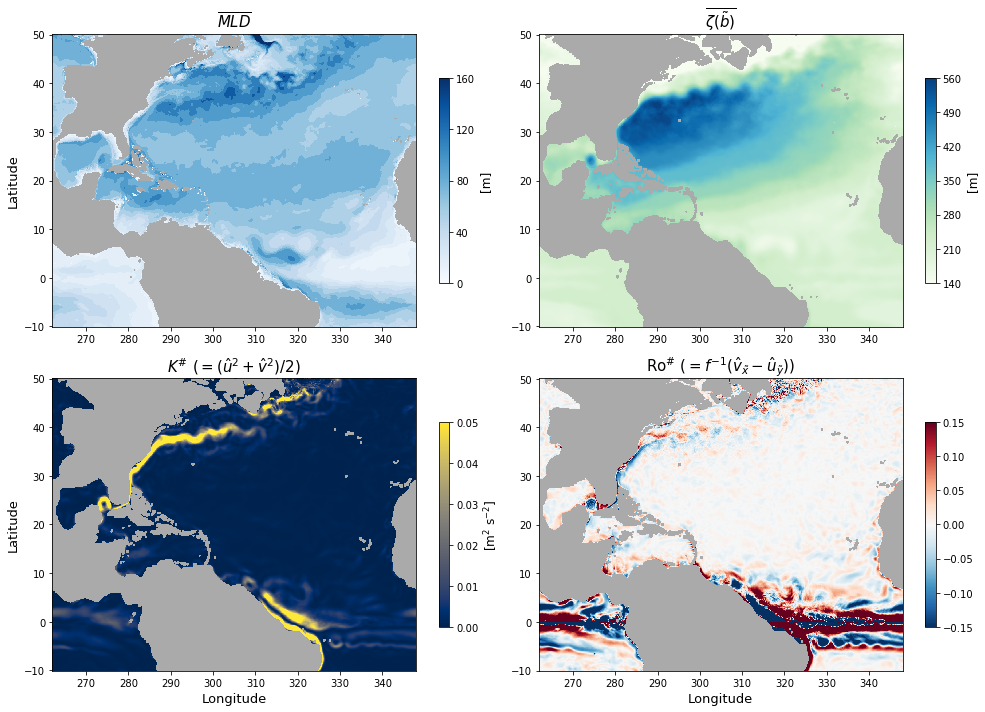

In [50]:
fig, axes = plt.subplots(figsize=(14,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(mld.XC, mld.YC.sel(YC=slice(ySstart+5-12**-1,
                                                       yend+2*12**-1)), 
                           -mld.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           vmin=0, vmax=160, cmap='Blues', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(ySstart+5-12**-1,
                                                                  yend+2*12**-1)
                                                        ).isel(sig=nsig).mean('nmemb'),
                           vmin=1.4e2, vmax=5.6e2, cmap='GnBu', rasterized=True)
im2 = axes[1,0].pcolormesh(KE.XC, KE.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           KE.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig), 
                           vmin=0, vmax=.05, cmap='cividis', rasterized=True)
im3 = axes[1,1].pcolormesh(uhat.XG, vhat.YG.sel(YG=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           Ro.sel(YG=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig),
                           vmin=-.15e0, vmax=.15e0, cmap='RdBu_r', rasterized=True)

axes[0,0].pcolormesh(mld.XC, mld.YC.sel(YC=slice(ySstart+5-12**-1, yend+2*12**-1)), 
                     np.ma.masked_array(maskMLD, ~maskMLD), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(KE.XC, KE.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(uhat.XG, vhat.YG.sel(YG=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\overline{MLD}$", fontsize=15)
axes[0,1].set_title(r"$\overline{\zeta(\tilde{b})}$", fontsize=15)
axes[1,0].set_title(r"$K^\#\ (=(\hat{u}^2 + \hat{v}^2)/2)$", fontsize=15)
axes[1,1].set_title(r"Ro$^\#\ (=f^{-1}(\hat{v}_\tilde{x}-\hat{u}_\tilde{y}))$", 
                    fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7, ticks=[0,40,80,120,160])
cbar0.set_label(r"[m]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7, ticks=[140,210,280,350,420,490,560])
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
# cbar3.set_label(r"[s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/mean_5Dave-delta_isig%02d_2008-Jan-03.pdf' % nsig))

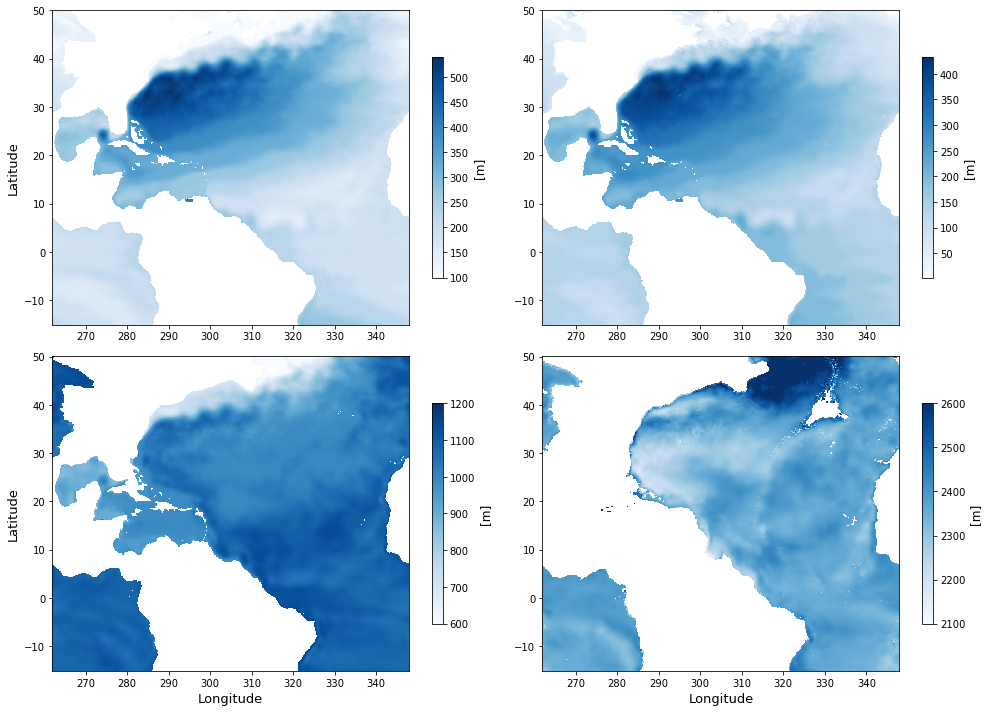

In [16]:
fig, axes = plt.subplots(figsize=(14,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(ySstart-12**-1,
                                                                  yend+2*12**-1)
                                                        ).isel(sig=nsig).mean('nmemb'),
                           vmin=1e2, vmax=5.4e2, cmap='Blues', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(ySstart-12**-1,
                                                                  yend+2*12**-1)
                                                        ).isel(sig=20).mean('nmemb'),
#                            vmin=2.2e2, vmax=3.9e2, 
                           cmap='Blues', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(ySstart-12**-1,
                                                                  yend+2*12**-1)
                                                        ).isel(sig=40).mean('nmemb'),
                           vmin=6e2, vmax=12e2, 
                           cmap='Blues', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(ySstart-12**-1,
                                                                  yend+2*12**-1)
                                                        ).isel(sig=50).mean('nmemb'),
                           vmin=2.1e3, vmax=2.6e3, 
                           cmap='Blues', rasterized=True)


axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m]", fontsize=12)

# plt.savefig(op.join(ddir,'Figures/zetas-adjusted_1963-Dec-26.pdf'))

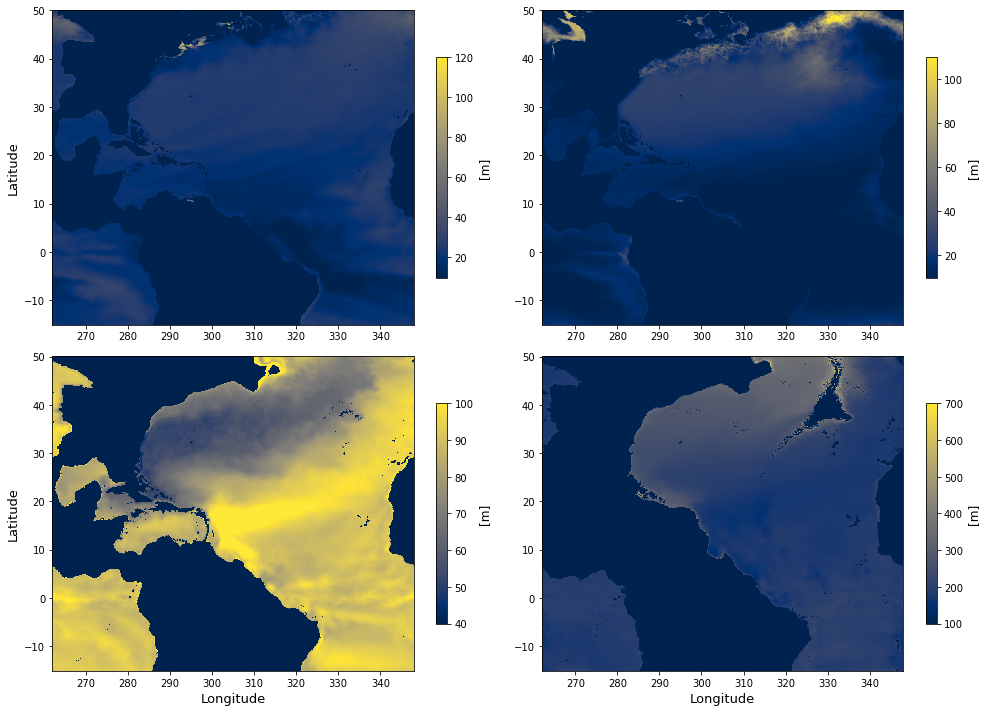

In [20]:
fig, axes = plt.subplots(figsize=(14,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsz.dzetaF.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)
                                         ).isel(sig=nsig).mean('nmemb'),
                           vmin=10, vmax=120, 
                           cmap='cividis', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsz.dzetaF.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)
                                         ).isel(sig=20).mean('nmemb'),
                           vmin=10, vmax=110, 
                           cmap='cividis', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsz.dzetaF.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)
                                         ).isel(sig=40).mean('nmemb'),
                           vmin=40, vmax=1e2, 
                           cmap='cividis', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsz.dzetaF.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)
                                         ).isel(sig=50).mean('nmemb'),
                           vmin=100, vmax=700, 
                           cmap='cividis', rasterized=True)


axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m]", fontsize=12)

# plt.savefig(op.join(ddir,'Figures/zeta_delta_isig20_1963-Dec-26.pdf'))

In [10]:
vort = (grid.diff(vhat*ds.dyC,'X') 
        - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
       ) * ds.rAz**-1
Pi = ((grid.interp(grid.interp(vort,'X'),'Y',boundary='fill') 
       + fC) * sigmab**-1)
Pi_f = (1. + grid.interp(grid.interp(vort,'X'),
                         'Y',boundary='fill') * fC**-1
       ) * sigmab**-1
Pi_f

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(96, 248, 15), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 21.0 21.27 21.54 21.81 ... 28.73 28.76 28.78 28.8
    iter     int64 7886160
    time     timedelta64[ns] 18255 days
    Depth    (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    maskInC  (YC, XC) int8 dask.array<chunksize=(392, 500), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>

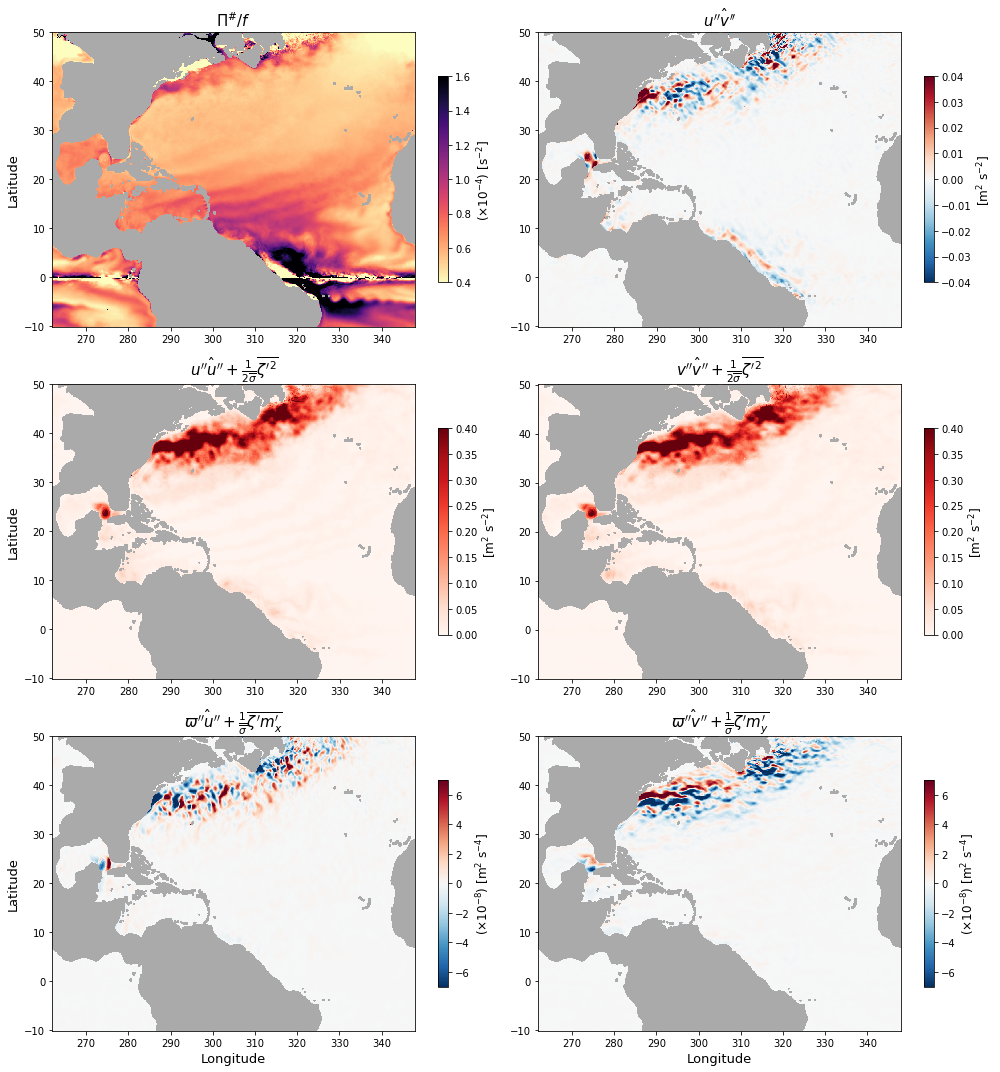

In [52]:
fig, axes = plt.subplots(figsize=(14,15), nrows=3, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           Pi_f.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e4, 
                           vmin=.4, vmax=1.6, cmap='magma_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           e01.isel(sig=nsig).sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           vmax=4e-2, vmin=-4e-2, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           e00.isel(sig=nsig).sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           vmax=4e-1, vmin=0, cmap='Reds', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YG.sel(YG=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           e11.isel(sig=nsig).sel(YG=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           vmax=4e-1, vmin=0, cmap='Reds', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           e20.isel(sig=nsig).sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1))*1e8, 
                           vmax=7e0, vmin=-7e0, cmap='RdBu_r', rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                           e21.isel(sig=nsig).sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1))*1e8, 
                           vmax=7e0, vmin=-7e0, cmap='RdBu_r', rasterized=True)

axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC, dsz.YG.sel(YG=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\Pi^\#/f$", fontsize=15)
axes[1,0].set_title(r"$\hat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", 
                    fontsize=15)
axes[0,1].set_title(r"$\hat{u''v''}$", fontsize=15)
axes[1,1].set_title(r"$\hat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", 
                    fontsize=15)
axes[2,0].set_title(r"$\hat{\varpi''u''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_x'}$", 
                    fontsize=15)
axes[2,1].set_title(r"$\hat{\varpi''v''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'}$", 
                    fontsize=15)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"$(\times 10^{-4})$ [s$^{-2}$]", fontsize=12)
# cbar0.ax.set_yticklabels(style='sci')
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
cbar4.set_label(r"$(\times 10^{-8})$ [m$^2$ s$^{-4}$]", fontsize=12)
cbar5 = fig.colorbar(im5, ax=axes[2,1], shrink=.7)
cbar5.set_label(r"$(\times 10^{-8})$ [m$^2$ s$^{-4}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/E-P_flux_5Dave-delta_isig%02d_2008-Jan-03.pdf' % nsig))

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


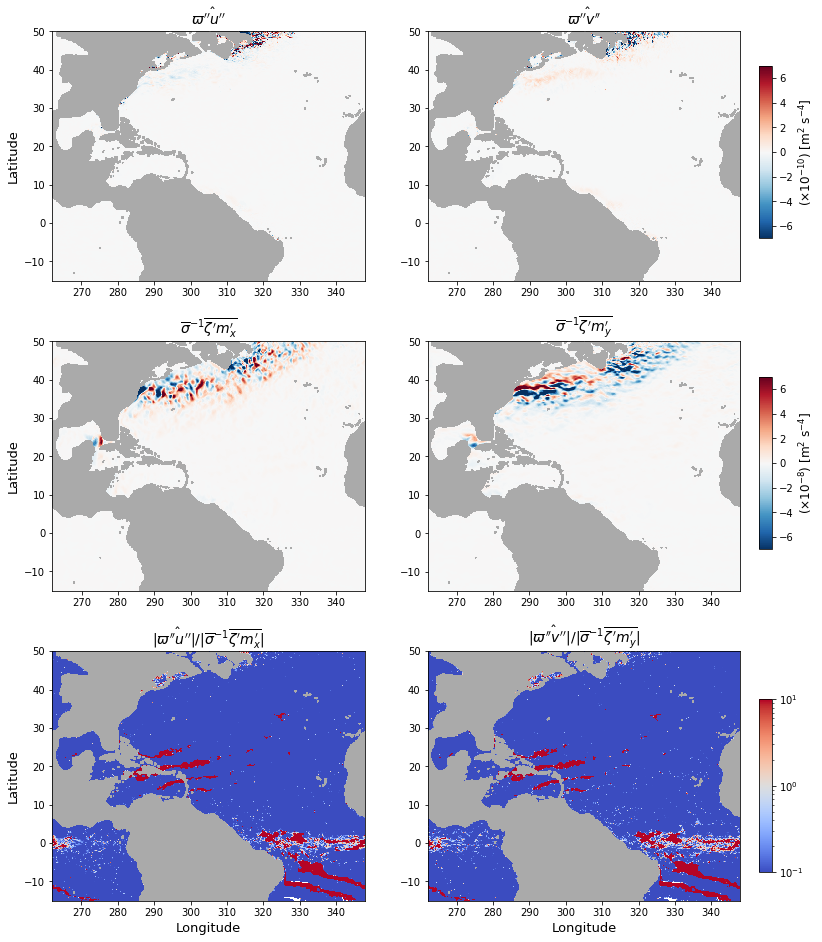

In [36]:
fig, axes = plt.subplots(figsize=(13,16), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsep.e20_0.sel(YC=slice(ySstart-12**-1,
                                                   yend+2*12**-1)).isel(sig=nsig)*1e10, 
                           vmax=7e0, vmin=-7e0, cmap='RdBu_r', rasterized=True)
im1 = axes[1,0].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsep.e20_1.sel(YC=slice(ySstart-12**-1,
                                                   yend+2*12**-1)).isel(sig=nsig)*1e8, 
                           vmax=7e0, vmin=-7e0, cmap='RdBu_r', rasterized=True)
im2 = axes[0,1].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsep.e21_0.sel(YC=slice(ySstart-12**-1,
                                                   yend+2*12**-1)).isel(sig=nsig)*1e10, 
                           vmax=7e0, vmin=-7e0, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YG.sel(YG=slice(ySstart-12**-1,yend+2*12**-1)), 
                           dsep.e21_1.sel(YC=slice(ySstart-12**-1,
                                                   yend+2*12**-1)).isel(sig=nsig)*1e8, 
                           vmax=7e0, vmin=-7e0, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           (np.abs(dsep.e20_0.isel(sig=nsig))
                            / np.abs(dsep.e20_1.isel(sig=nsig))
                           ).sel(YC=slice(ySstart-12**-1,yend+2*12**-1)),
                           norm=clr.LogNorm(vmax=1e1, vmin=1e-1), 
                           cmap='coolwarm', rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           (np.abs(dsep.e21_0.isel(sig=nsig))
                            / np.abs(dsep.e21_1.isel(sig=nsig))
                           ).sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           norm=clr.LogNorm(vmax=1e1, vmin=1e-1), 
                           cmap='coolwarm', rasterized=True)

axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XG, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC, dsz.YG.sel(YG=slice(ySstart-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\hat{\varpi''u''}$", fontsize=14)
axes[1,0].set_title(r"$\overline{\sigma}^{-1}\overline{\zeta'm_x'}$", 
                    fontsize=14)
axes[0,1].set_title(r"$\hat{\varpi''v''}$", fontsize=14)
axes[1,1].set_title(r"$\overline{\sigma}^{-1}\overline{\zeta'm_y'}$", 
                    fontsize=14)
axes[2,0].set_title(r"$|\hat{\varpi''u''}|/|\overline{\sigma}^{-1}\overline{\zeta'm_x'}|$", 
                    fontsize=14)
axes[2,1].set_title(r"$|\hat{\varpi''v''}|/|\overline{\sigma}^{-1}\overline{\zeta'm_y'}|$", 
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.24) 
cbax0 = fig.add_axes([0.88, 0.7, 0.014, 0.15])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"$(\times 10^{-10})$ [m$^2$ s$^{-4}$]", fontsize=12)
cbax1 = fig.add_axes([0.88, 0.43, 0.014, 0.15])
cbar1 = fig.colorbar(im1, orientation='vertical', cax=cbax1)
cbar1.set_label(r"$(\times 10^{-8})$ [m$^2$ s$^{-4}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.15, 0.014, 0.15])
cbar2 = fig.colorbar(im4, orientation='vertical', cax=cbax2)
# cbar2.set_label(r"[m$^{-1}$ s$^{-3}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/Adiab_barocli_5Dave-delta_isig%02d_2008-Jan-03.pdf' % nsig))

In [11]:
varpidz = dsvarpi.diadz + dsvarpi.cmpdz
varpihat = (varpidz.mean('nmemb',skipna=True) 
            * dsz.dzetaF.mean('nmemb',skipna=True)**-1
           )

vpp = dsmn.vdz*dsz.dzetaFy**-1 - vhat
upp = dsmn.udz*dsz.dzetaFx**-1 - uhat
varpipp = varpidz*dsz.dzetaF**-1 - varpihat

In [12]:
e00 = dsep.e00
e10 = dsep.e10
e20 = dsep.e20_0 + dsep.e20_1
e01 = dsep.e01
e11 = dsep.e11
e21 = dsep.e21_0 + dsep.e21_1
e00

<xarray.DataArray 'e00' (YC: 783, XG: 1000, sig: 60)>
dask.array<zarr, shape=(783, 1000, 60), dtype=float64, chunksize=(98, 125, 15), chunktype=numpy.ndarray>
Coordinates:
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
    dxC      (YC, XG) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    dyG      (YC, XG) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    iter     int64 ...
    maskInW  (YC, XG) int8 dask.array<chunksize=(392, 500), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
  * sig      (sig) float64 21.0 21.27 21.54 21.81 ... 28.73 28.76 28.78 28.8
    time     timedelta64[ns] ...

### ${\bf u}C$ is a flux, so ${\bf u}u$ is also a flux. Hence, ${\bf u}(u\sigma)$ would also be a flux. $\zeta^2$ nor $\zeta \nabla m$ though are not fluxes.

In [13]:
e00_x = dsep.e00x
e10_y = dsep.e10y
e20_b = dsep.e20_0b + dsep.e20_1b
e01_x = dsep.e01x
e11_y = dsep.e11y
e21_b = dsep.e21_0b + dsep.e21_1b
print(e20_b, e21_b)

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<add, shape=(783, 1000, 60), dtype=float64, chunksize=(98, 125, 15), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
    iter     int64 7886160
    maskInC  (YC, XC) bool dask.array<chunksize=(392, 500), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
  * sig      (sig) float64 21.0 21.27 21.54 21.81 ... 28.73 28.76 28.78 28.8
    time     timedelta64[ns] 18255 days <xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<add, shape=(783, 1000, 60), dtype=float64, chunksize=(98, 125, 15), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17

In [14]:
Eu = e00_x + e10_y + e20_b
Ev = e01_x + e11_y + e21_b
PVpx = sigmab**-1 * Ev
PVpy = -sigmab**-1 * Eu

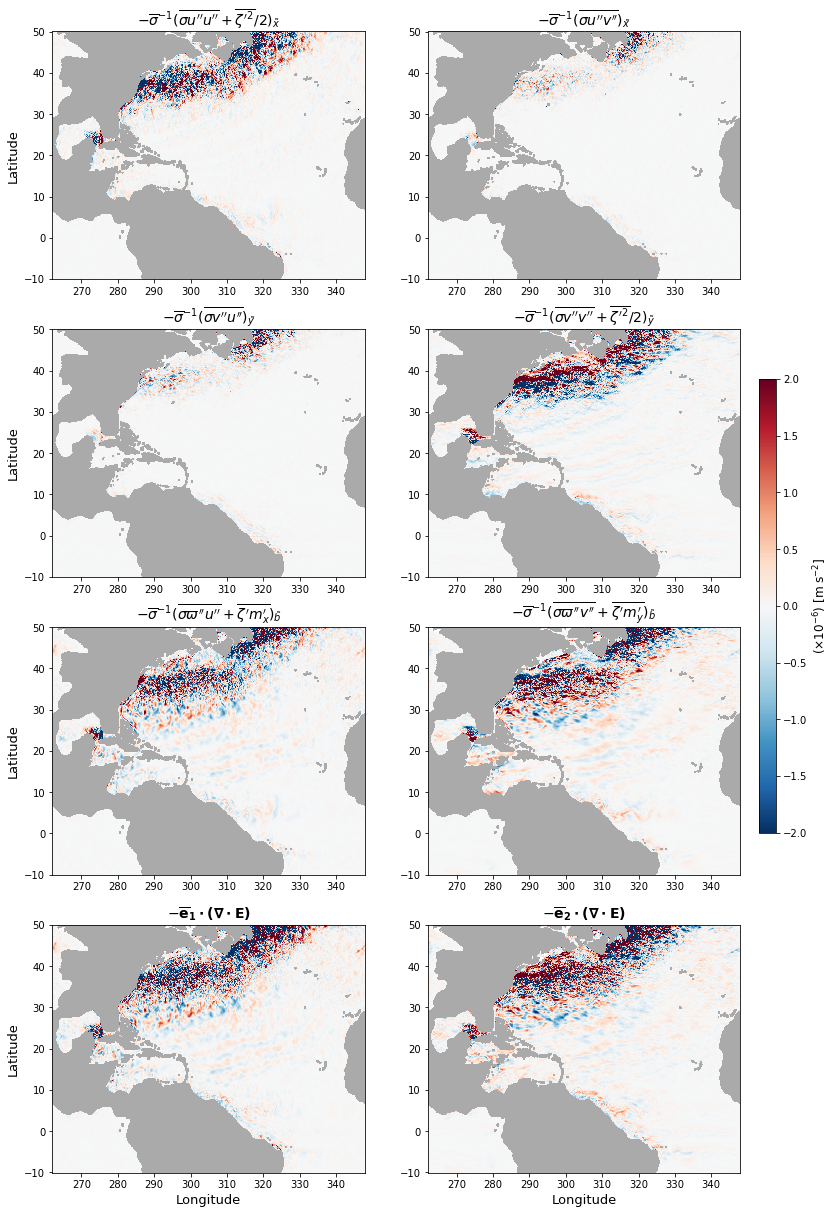

In [55]:
fig, axes = plt.subplots(figsize=(13,21), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                          -e00_x.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                          vmax=2.e0, vmin=-2.e0,
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     -e10_y.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                     vmax=2.e0, vmin=-2.e0,
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     -e01_x.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                     vmax=2.e0, vmin=-2.e0,
                     cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     -e11_y.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                     vmax=2.e0, vmin=-2.e0,
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(e20_b.XC, e20_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     -e20_b.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                     vmax=2.e0, vmin=-2.e0,
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(e21_b.XC, e21_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     -e21_b.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                     vmax=2.e0, vmin=-2.e0,
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     -Eu.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                     vmax=2.e0, vmin=-2.e0,
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     -Ev.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)).isel(sig=nsig)*1e6, 
                     vmax=2.e0, vmin=-2.e0,
                     cmap='RdBu_r', rasterized=True)

axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(ySstart+5-12**-1,yend+2*12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                    fontsize=14)
axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                    fontsize=14)
axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                    fontsize=14)
axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                    fontsize=14)
axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=14)
axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=14)
axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

axes[3,0].set_xlabel(r"Longitude", fontsize=13)
axes[3,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)
axes[3,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
                    ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.])
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"$(\times 10^{-6})$ [m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/DivE-P_flux_5Dave-delta_isig%02d_2008-Jan-03.pdf' % nsig))

In [17]:
GSs, GSn = (11,44)
GSw, GSe = (290,305)
mskv = np.ma.masked_invalid(Ev.sel(YC=slice(GSs,GSn),
                                   XC=slice(GSw,GSe)
                                  ).mean('XC',skipna=True).isel(sig=slice(12,50))
                           ).mask
maskM = xr.DataArray(np.ma.masked_array(np.ma.masked_invalid(Eu.sel(YC=slice(GSs,GSn),
                                                                    XC=slice(GSw,GSe)
                                       ).mean('XC',skipna=True).isel(sig=slice(12,50))), 
                                        mskv).mask,
                     dims=['YC','sig'], 
                     coords=Eu.sel(YC=slice(GSs,GSn)
                                  ).sel(XC=300, method='nearest'
                                       ).isel(sig=slice(12,50)).coords
                    )
maskM

<xarray.DataArray (YC: 396, sig: 38)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
    Depth    (YC) float32 dask.array<chunksize=(79,), meta=np.ndarray>
    XC       float32 300.0379
  * YC       (YC) float64 11.0 11.08 11.17 11.25 ... 43.67 43.75 43.83 43.92
    iter     int64 7886160
    maskInC  (YC) bool dask.array<chunksize=(79,), meta=np.ndarray>
    rA       (YC) float32 dask.array<chunksize=(79,), meta=np.ndarray>
  * sig      (sig) float64 24.08 24.31 24.53 24.75 ... 28.39 28.43 28.48 28.52
    time     timedelta64[ns] 18255 days

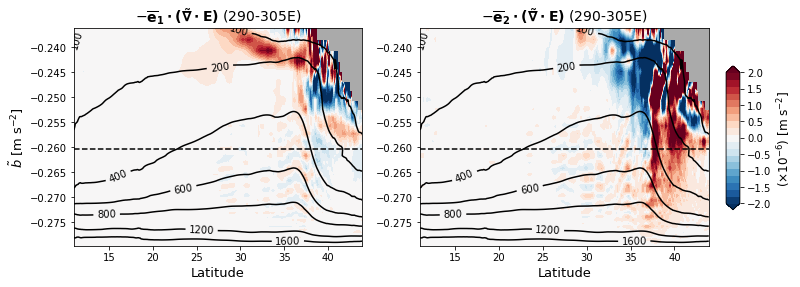

In [19]:
sigaxis = np.array([28.5,27.5,26.5,25.5,24.5])
baxis = -grav*sigaxis/rhoConst

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

cs1 = ax1.contourf(dsz.YC.sel(YC=slice(GSs,GSn)), buoyb.isel(sig=slice(12,50)),
                   -Eu.sel(YC=slice(GSs,GSn),
                           XC=slice(GSw,GSe)
                          ).mean('XC',skipna=True).isel(sig=slice(12,50)).T*1e6,
                   levels=np.linspace(-2,2,20), extend='both', cmap='RdBu_r')
cs2 = ax2.contourf(dsz.YC.sel(YC=slice(GSs,GSn)), buoyb.isel(sig=slice(12,50)),
                   -Ev.sel(YC=slice(GSs,GSn),
                           XC=slice(GSw,GSe)
                          ).mean('XC',skipna=True).isel(sig=slice(12,50)).T*1e6,
                   levels=np.linspace(-2,2,20), extend='both', cmap='RdBu_r')
cs3 = ax1.contour(dsz.YC.sel(YC=slice(GSs,GSn)), buoyb.isel(sig=slice(12,50)),
                  -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(GSs,GSn),
                                                XC=slice(GSw,GSe)
                                               ).mean('XC',skipna=True
                                                     ).isel(sig=slice(12,50)).mean('nmemb').T,
                  levels=np.array([100,200,400,600,800,1200,1600]), colors='k')
cs4 = ax2.contour(dsz.YC.sel(YC=slice(GSs,GSn)), buoyb.isel(sig=slice(12,50)),
                  -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(GSs,GSn),
                                                XC=slice(GSw,GSe)
                                               ).mean('XC',skipna=True
                                                     ).isel(sig=slice(12,50)).mean('nmemb').T,
                  levels=np.array([100,200,400,600,800,1200,1600]), colors='k')

ax1.pcolormesh(dsz.YC.sel(YC=slice(GSs,GSn)), buoyb.isel(sig=slice(12,50)), 
               maskM.where(maskM).T,
               vmin=0, vmax=3, cmap='binary', rasterized=True)
ax2.pcolormesh(dsz.YC.sel(YC=slice(GSs,GSn)), buoyb.isel(sig=slice(12,50)), 
               maskM.where(maskM).T,
               vmin=0, vmax=3, cmap='binary', rasterized=True)
ax1.plot(dsz.YC.sel(YC=slice(GSs,GSn)),
         xr.ones_like(dsz.YC.sel(YC=slice(GSs,GSn)))*buoyb.isel(sig=nsig),
         'k--')
ax2.plot(dsz.YC.sel(YC=slice(GSs,GSn)),
         xr.ones_like(dsz.YC.sel(YC=slice(GSs,GSn)))*buoyb.isel(sig=nsig),
         'k--')


ax1.clabel(cs3, inline=True, fontsize=10, fmt='%.f')
ax2.clabel(cs4, inline=True, fontsize=10, fmt='%.f')
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)
for c in cs4.collections:
    c.set_rasterized(True)
    
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(cs1, orientation='vertical', cax=cbaxes,
                    ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.])
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"$(\times 10^{-6})$ [m s$^{-2}$]", fontsize=12)
    
ax1.set_title(r"$-\overline{\bf e}_1\cdot(\tilde{\nabla}\cdot{\bf E})$ (290-305E)", 
              fontsize=14)
ax2.set_title(r"$-\overline{\bf e}_2\cdot(\tilde{\nabla}\cdot{\bf E})$ (290-305E)", 
              fontsize=14)
ax1.set_xlabel(r"Latitude", fontsize=13)
ax2.set_xlabel(r"Latitude", fontsize=13)
ax1.set_ylabel(r"$\tilde{b}$ [m s$^{-2}$]", fontsize=13)
# ax1.set_yticks(sigaxis)
# ax2.set_yticks(sigaxis)
# ax1.set_yticklabels(np.round(baxis,2))
# ax2.set_yticklabels(np.round(baxis,2))
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
plt.savefig(op.join(ddir,'Figures/DivE-P_flux_5Dave-delta_2008-Jan-03_GSext.pdf'))

In [23]:
print(buoyb.isel(sig=nsig))
buoyb

<xarray.DataArray 'sig' ()>
array(-0.26035238)
Coordinates:
    iter     int64 ...
    sig      float64 26.53
    time     timedelta64[ns] ...


<xarray.DataArray 'sig' (sig: 60)>
array([-0.20605121, -0.20870323, -0.21134936, -0.21398378, -0.21660076,
       -0.21919472, -0.2217603 , -0.22429235, -0.22678602, -0.22923676,
       -0.23164039, -0.23399306, -0.23629132, -0.23853212, -0.2407128 ,
       -0.24283108, -0.24488513, -0.24687345, -0.24879495, -0.25064889,
       -0.25243487, -0.2541528 , -0.25580291, -0.25738568, -0.25890185,
       -0.26035238, -0.26173842, -0.26306131, -0.26432252, -0.26552366,
       -0.26666644, -0.26775265, -0.26878416, -0.26976288, -0.27069073,
       -0.2715697 , -0.27240173, -0.27318878, -0.2739328 , -0.2746357 ,
       -0.27529936, -0.27592563, -0.27651629, -0.2770731 , -0.27759776,
       -0.2780919 , -0.27855711, -0.2789949 , -0.27940675, -0.27979406,
       -0.28015816, -0.28050036, -0.28082186, -0.28112385, -0.28140744,
       -0.28167368, -0.28192358, -0.28215809, -0.28237812, -0.28258452])
Coordinates:
    iter     int64 ...
  * sig      (sig) float64 21.0 21.27 21.54 21.81 ... 28.73 28.76 28.78 28.8
    time     timedelta64[ns] ...

### Since we're taking $v_\tilde{x}$ and $u_\tilde{y}$ consist with the finite-volume discretization, it makes sense to take $v_{\tilde{x}\tilde{x}}$ for example in the same manner.

In [44]:
def hann_filt(da, area=None, dim=['YC','XC'], nker=5, cutoff=3):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    return da_LS

#########################
ny, nx, nb = (13,13,1)
def med_filt(da, nker=np.ones((ny,nx,nb))):
#     if area is not None:
#         da = da*area
    return xr.DataArray(dsfilt.median_filter(da.data, footprint=nker), 
                        dims=da.dims, coords=da.coords)

# def gaus_filt(da, sig=1, trunc=4):
#     return xr.DataArray(dsfilt.gaussian_filter(da.data, sigma=sig, mode=('nearest','wrap'),
#                                                truncate=trunc),
#                         dims=da.dims, coords=da.coords)

#########################
def _dot(self, other):
    func = np.dot(self[0,0,0], other[0,0,0])
    return np.expand_dims(func, (0,1,2))

In [45]:
vort_x = grid.diff(vort,'X') * ds.dxG**-1
vort_y = grid.diff(vort,'Y',boundary='fill') * ds.dyG**-1

zetab_x = grid.diff(zetaxb,'X')*grid.interp(ds.dxC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)),
                                            'X')**-1
zetab_y = grid.diff(zetayb,'Y',boundary='fill')*grid.interp(ds.dyC.sel(YG=slice(ySstart-12**-1,
                                                                                yend+2*12**-1)),
                                                            'Y',boundary='fill')**-1

sigmab_x = grid.interp(grid.diff(zetab_x,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')
sigmab_y = grid.interp(grid.diff(zetab_y,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')


cf = 11
nk = 15
Pi_sm = hann_filt(Pi.chunk({'YC':ychunk,'XC':xchunk}), nker=nk, cutoff=cf)
absvort = fC + grid.interp(grid.interp(vort,'X'),'Y',boundary='fill')
Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
         - sigmab_x * sigmab**-1 * absvort)
Pi_ys = (grid.diff(fG,'Y',boundary='fill') 
         * grid.interp(ds.dyG.sel(YC=slice(ySstart-12**-1,
                                           yend+2*12**-1)),'X')**-1 
         + grid.interp(vort_y,'X')
        ) - sigmab_y * sigmab**-1 * absvort

Pism_x = grid.diff(Pi_sm,'X') * ds.dxC**-1
Pism_y = grid.diff(Pi_sm,'Y',boundary='fill') * ds.dyC**-1
Pi_x = Pi_xs * sigmab**-1
Pi_y = Pi_ys * sigmab**-1

print(Pi_y, Pi_x)

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(96, 248, 13), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 21.0 21.27 21.54 21.81 ... 28.73 28.76 28.78 28.8
    Depth    (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    iter     int64 7886160
    maskInC  (YC, XC) int8 dask.array<chunksize=(392, 500), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    time     timedelta64[ns] 18255 days <xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(96, 248, 13), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XC       (XC) float32 262.00003 262.0861 262.17

In [48]:
that = dsmn.tdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
shat = dsmn.sdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
that_sm = hann_filt(that, nker=nk, cutoff=cf)
shat_sm = hann_filt(shat, nker=nk, cutoff=cf)

thatsm_x = grid.diff(that_sm,'X') * ds.dxC**-1
thatsm_y = grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1
shatsm_x = grid.diff(shat_sm,'X') * ds.dxC**-1
shatsm_y = grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1
that_x = grid.diff(that,'X') * ds.dxC**-1
that_y = grid.diff(that,'Y',boundary='fill') * ds.dyC**-1
shat_x = grid.diff(shat,'X') * ds.dxC**-1
shat_y = grid.diff(shat,'Y',boundary='fill') * ds.dyC**-1

#########################################################
tpp = (dsmn.tdz * dsz.dzetaF**-1) - that
spp = (dsmn.sdz * dsz.dzetaF**-1) - shat
upptpphat = (upp*grid.interp(tpp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
uppspphat = (upp*grid.interp(spp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1

# print(that_x, that_y, shat_x, shat_y, upptpphat, vpptpphat)

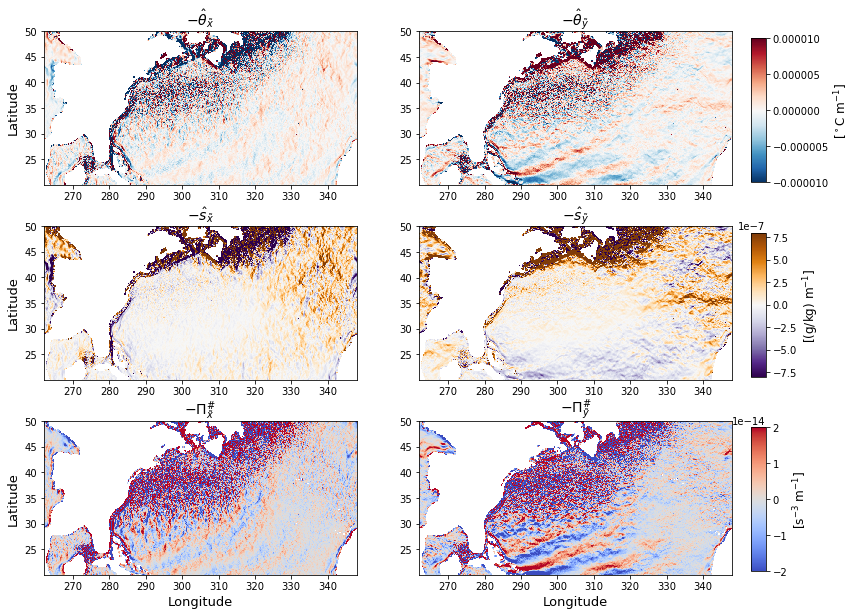

In [25]:
fig, axes = plt.subplots(figsize=(13,10), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -that_x.isel(sig=nsig).sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-1e-5, vmax=1e-5, 
                           cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YG.sel(YG=slice(yNstart+5,yend+12**-1)), 
                           -that_y.isel(sig=nsig).sel(YG=slice(yNstart+5,yend+12**-1)), 
                           vmin=-1e-5, vmax=1e-5, 
                           cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -shat_x.isel(sig=nsig).sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-8e-7, vmax=8e-7, 
                           cmap='PuOr_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YG.sel(YG=slice(yNstart+5,yend+12**-1)), 
                           -shat_y.isel(sig=nsig).sel(YG=slice(yNstart+5,yend+12**-1)), 
                           vmin=-8e-7, vmax=8e-7, 
                           cmap='PuOr_r', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -Pi_x.isel(sig=nsig).sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-2e-14, vmax=2e-14, 
                           cmap='coolwarm', rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -Pi_y.isel(sig=nsig).sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-2e-14, vmax=2e-14, 
                           cmap='coolwarm', rasterized=True)


axes[0,0].set_title(r"$-\hat{\theta}_\tilde{x}$", fontsize=14)
axes[0,1].set_title(r"$-\hat{\theta}_\tilde{y}$", fontsize=14)
axes[1,0].set_title(r"$-\hat{s}_\tilde{x}$", fontsize=14)
axes[1,1].set_title(r"$-\hat{s}_\tilde{y}$", fontsize=14)
axes[2,0].set_title(r"$-\Pi^\#_\tilde{x}$", fontsize=14)
axes[2,1].set_title(r"$-\Pi^\#_\tilde{y}$", fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27) 
cbax0 = fig.add_axes([0.88, 0.67, 0.016, 0.2])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[$^\circ$C m$^{-1}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.4, 0.016, 0.2])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[(g/kg) m$^{-1}$]", fontsize=12)
cbax4 = fig.add_axes([0.88, 0.13, 0.016, 0.2])
cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
cbar4.set_label(r"[s$^{-3}$ m$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/Tracer_grad_5Dave-delta_no-filter_2008-Jan-03.pdf'))

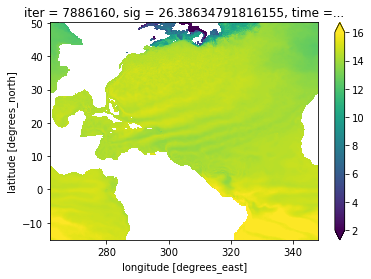

In [34]:
that.isel(sig=nsig).plot(vmin=2, vmax=16)

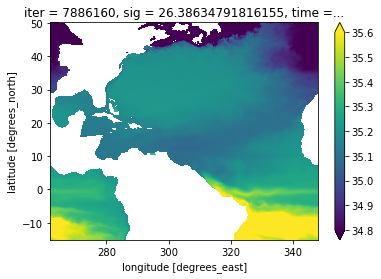

In [39]:
shat.isel(sig=nsig).plot(vmin=34.8, vmax=35.6)

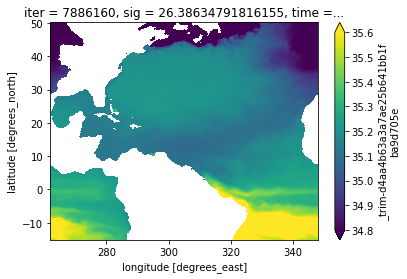

In [40]:
shat_sm.isel(sig=nsig).plot(vmin=34.8, vmax=35.6)

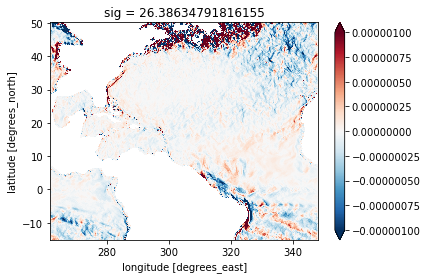

In [41]:
shatsm_x.isel(sig=nsig).plot(vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')

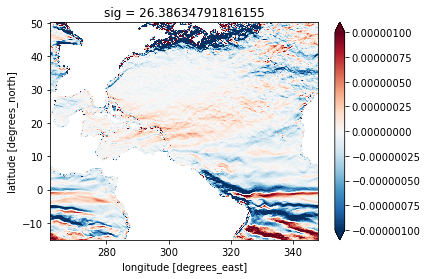

In [42]:
shatsm_y.isel(sig=nsig).plot(vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')

In [49]:
uptphat_sm = hann_filt(upptpphat.chunk({'YC':ychunk,'XG':xchunk}), dim=['YC','XG'], nker=nk, cutoff=cf)
vptphat_sm = hann_filt(vpptpphat.chunk({'YG':ychunk,'XC':xchunk}), dim=['YG','XC'], nker=nk, cutoff=cf)
upsphat_sm = hann_filt(uppspphat.chunk({'YC':ychunk,'XG':xchunk}), dim=['YC','XG'], nker=nk, cutoff=cf)
vpsphat_sm = hann_filt(vppspphat.chunk({'YG':ychunk,'XC':xchunk}), dim=['YG','XC'], nker=nk, cutoff=cf)
PVpx_sm = hann_filt(PVpx, dim=['YC','XC'], nker=nk, cutoff=cf)
PVpy_sm = hann_filt(PVpy, dim=['YC','XC'], nker=nk, cutoff=cf)

In [50]:
l = nsig
ut = grid.interp(uptphat_sm.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vt = grid.interp(vptphat_sm.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
us = grid.interp(upsphat_sm.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vs = grid.interp(vpsphat_sm.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
uPV = PVpx_sm.isel(sig=l).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vPV = PVpy_sm.isel(sig=l).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()


tx_sm = grid.interp(thatsm_x.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
ty_sm = grid.interp(thatsm_y.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sx_sm = grid.interp(shatsm_x.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sy_sm = grid.interp(shatsm_y.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVx_sm = grid.interp(Pism_x.isel(sig=l),'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVy_sm = grid.interp(Pism_y.isel(sig=l),'Y',
                     boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()

In [51]:
ut_norm = (ut * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1)
vt_norm = (vt * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1)
us_norm = (us * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
vs_norm = (vs * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
uPV_norm = (uPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)
vPV_norm = (vPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)

tx_norm = (tx_sm * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1)
ty_norm = (ty_sm * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1)
sx_norm = (sx_sm * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
sy_norm = (sy_sm * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)

PVx_norm = (PVx_sm * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)
PVy_norm = (PVy_sm * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)

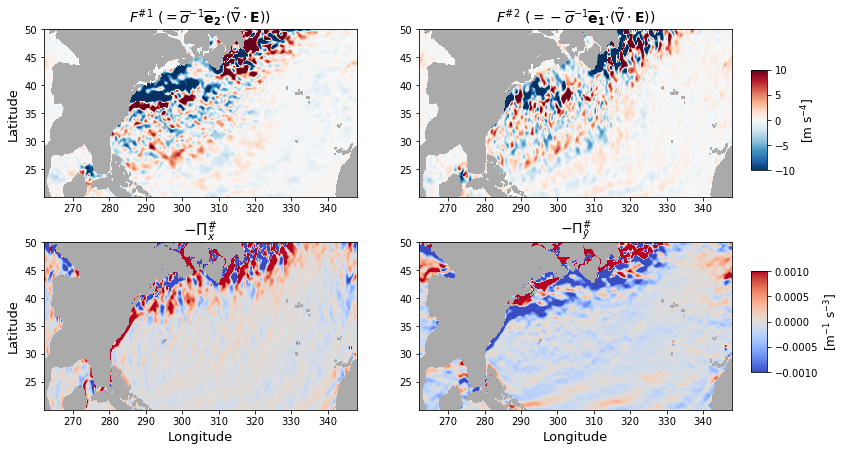

In [55]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           uPV_norm.sel(YC=slice(yNstart+5,yend+12**-1)),
                           vmin=-10e0, vmax=10e0, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vPV_norm.sel(YC=slice(yNstart+5,yend+12**-1)),
                           vmin=-10e0, vmax=10e0, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -PVx_norm.sel(YC=slice(yNstart+5,yend+12**-1)),
                           vmin=-1e-3, vmax=1e-3, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -PVy_norm.sel(YC=slice(yNstart+5,yend+12**-1)),
                           vmin=-1e-3, vmax=1e-3, cmap='coolwarm', rasterized=True)

axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$F^{\#1}$ $(= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[0,1].set_title(r"$F^{\#2}$ $(= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[1,0].set_title(r"$-\Pi^\#_\tilde{x}$", fontsize=15)
axes[1,1].set_title(r"$-\Pi^\#_\tilde{y}$", 
                    fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27) 
cbax0 = fig.add_axes([0.88, 0.6, 0.018, 0.2])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m s$^{-4}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[m$^{-1}$ s$^{-3}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/PV_flux_5Dave-delta_Hann-ker%02d_2008-Jan-03.pdf' % nk))

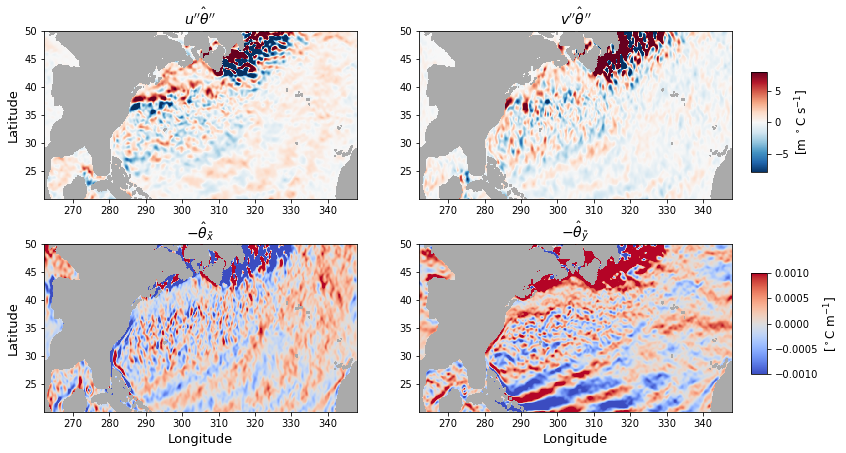

In [56]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           ut_norm.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-8e0, vmax=8e0, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vt_norm.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-8e0, vmax=8e0, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -tx_norm.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-1e-3, vmax=1e-3, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -ty_norm.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-1e-3, vmax=1e-3, cmap='coolwarm', rasterized=True)

axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\hat{u''\theta''}$", fontsize=14)
axes[0,1].set_title(r"$\hat{v''\theta''}$", fontsize=14)
axes[1,0].set_title(r"$-\hat{\theta}_\tilde{x}$", fontsize=14)
axes[1,1].set_title(r"$-\hat{\theta}_\tilde{y}$", fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27) 
cbax0 = fig.add_axes([0.88, 0.6, 0.018, 0.2])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m $^\circ$C s$^{-1}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[$^\circ$C m$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/THETA_flux_5Dave-delta_Hann-ker%02d_2008-Jan-03.pdf' % nk))

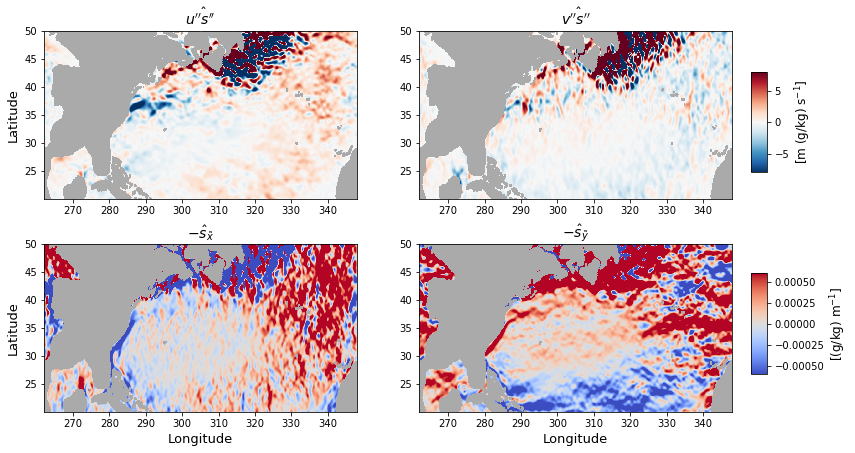

In [57]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           us_norm.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-8e0, vmax=8e0, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vs_norm.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           vmin=-8e0, vmax=8e0, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -sx_norm.sel(YC=slice(yNstart+5,yend+12**-1)),
                           vmin=-6e-4, vmax=6e-4, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                           -sy_norm.sel(YC=slice(yNstart+5,yend+12**-1)),
                           vmin=-6e-4, vmax=6e-4, cmap='coolwarm', rasterized=True)

axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)), 
                     np.ma.masked_array(maskNS, ~maskNS),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\hat{u''s''}$", fontsize=14)
axes[0,1].set_title(r"$\hat{v''s''}$", fontsize=14)
axes[1,0].set_title(r"$-\hat{s}_\tilde{x}$", fontsize=14)
axes[1,1].set_title(r"$-\hat{s}_\tilde{y}$", fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27) 
cbax0 = fig.add_axes([0.88, 0.6, 0.018, 0.2])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m (g/kg) s$^{-1}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[(g/kg) m$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/SALT_flux_5Dave-delta_Hann-ker%02d_2008-Jan-03.pdf' % nk))

# Compute the "$\kappa$"s.

In [49]:
dxT = grid.interp(ds.dxG,'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyT = grid.interp(ds.dyG,'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyU = ds.dyG.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dxV = ds.dxG.sel(YG=slice(yNstart+5,yend+2*12**-1)).load()
sigmaT = sigma.isel(sig=nsig).sel(YC=slice(yNstart+5,yend+2*12**-1)).mean('nmemb').load()
sigmaU = sigmax.isel(sig=nsig).sel(YC=slice(yNstart+5,yend+2*12**-1)).mean('nmemb').load()
sigmaV = sigmay.isel(sig=nsig).sel(YG=slice(yNstart+5,yend+2*12**-1)).mean('nmemb').load()
# print(dxT.shape, dyT.shape, dyU.shape, dxV.shape)

In [62]:
xlim = [270,340]

In [84]:
K = xr.DataArray(np.ones((len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),
                          len(dsz.XC.sel(XC=slice(xlim[0],xlim[1]))),1,2,2))*np.nan,
                 dims=['YC','XC','sig','col','row'],
                 coords={'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data,
                         'XC':dsz.XC.sel(XC=slice(xlim[0],xlim[1])).data,
                         'sig':np.array([dsz.sig.isel(sig=l)])}
                )

n = 0
for j in dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data:
    if n % 40 == 0:
        print('lat =', j)

    for m in dsz.XC.sel(XC=slice(xlim[0],xlim[1])).data:

        dataF = np.array([ 
                          [ ut_norm.sel(YC=j,XC=m).data,    vt_norm.sel(YC=j,XC=m).data],
                          [ us_norm.sel(YC=j,XC=m).data,    vs_norm.sel(YC=j,XC=m).data],
                          [uPV_norm.sel(YC=j,XC=m).data,   vPV_norm.sel(YC=j,XC=m).data],
                         ])
        F = dataF

#################################
        dataG = np.array([ 
                          [ -tx_norm.sel(YC=j,XC=m).data,    -ty_norm.sel(YC=j,XC=m).data],
                          [ -sx_norm.sel(YC=j,XC=m).data,    -sy_norm.sel(YC=j,XC=m).data],
                          [-PVx_norm.sel(YC=j,XC=m).data,   -PVy_norm.sel(YC=j,XC=m).data],
                         ])
        G = dataG
#################################
        if ~(np.isnan(F).any() or np.isnan(G).any()):
            K.sel(YC=j,XC=m).isel(sig=0)[:] = np.linalg.pinv(G).dot(F)
        
        if m == dsz.XC.sel(XC=slice(xlim[0],xlim[1]))[0].data \
            and j == dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[0].data:
            print(K.sel(YC=j,XC=m).isel(sig=0))
    n += 1


itime = 7886160
K.to_dataset(name='K').to_netcdf(op.join(ddir,
                    '5Dave/run%4d/Diff-tensor_5Dave-delta_isig%02d_%010d_Hann-ker%02d.nc' 
                                         % (year,l,itime,nk)))
K

lat = 20.00003433227539
<xarray.DataArray (col: 2, row: 2)>
array([[nan, nan],
       [nan, nan]])
Coordinates:
    YC       float64 20.0
    XC       float32 270.00348
    sig      float64 26.53
Dimensions without coordinates: col, row
lat = 23.3333683013916
lat = 26.666702270507812
lat = 30.00003433227539
lat = 33.33336639404297
lat = 36.66670227050781
lat = 40.00003433227539
lat = 43.333370208740234
lat = 46.66670227050781
lat = 50.00003433227539


<xarray.DataArray (YC: 361, XC: 814, sig: 1, col: 2, row: 2)>
array([[[[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[ 6.48886014e+02,  6.88116470e+01],
          [ 3.06303519e+02,  8.32857097e+02]]],


        [[[ 5.42741281e+02, -8.44606886e+01],
          [-1.96543082e+01,  4.24519084e+02]]],


        [[[ 4.72455335e+02, -2.90079579e+02],
          [-1.37869897e+02,  9.61654571e+01]]]],



       [[[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[ 9.82379063e+02,  2.08085728e+02],
          [ 8.84763404e+02,  9.15360752e+02]]],


        [[[ 8.48482396e+02, -8.91694131e+01],
          [ 3.83342640e+02,  2.66870816e+02]]],


        [[[ 7.68870804e+02, -3.23416829e+02],
          [ 1.57666824e+02, -2.50206648e+01]]]],



       [[[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[ 1.54108442e+03,  4.32460503e+02],
          [ 1.74920241e+03,  1.10438150e+03]]],


        [[[ 1.36351345e+03, -1.07263757e+02],
          [ 1.03655288e+03,  1.08008917e+02]]],


        [[[ 1.15811154e+03, -2.18005921e+02],
          [ 5.70980338e+02,  3.14795072e+01]]]],



       ...,



       [[[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[ 5.11636334e+03,  2.90289222e+03],
          [-6.85066303e+03, -1.80042336e+04]]],


        [[[ 5.60684112e+03,  2.62617686e+03],
          [-6.18758407e+03, -1.14119918e+04]]],


        [[[ 6.40041445e+03,  2.02825903e+03],
          [-6.76081154e+03, -6.92104672e+03]]]],



       [[[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[ 6.45917810e+03,  1.24764988e+03],
          [-2.37039709e+04, -1.79948430e+04]]],


        [[[ 7.36626460e+03,  1.39256023e+03],
          [-2.00481851e+04, -1.19530675e+04]]],


        [[[ 8.55733922e+03,  1.12959577e+03],
          [-1.93967235e+04, -7.43093934e+03]]]],



       [[[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[ 6.56523596e+03,  2.87489413e+02],
          [-5.15618737e+04, -2.06806824e+04]]],


        [[[ 7.90031428e+03,  5.50045296e+02],
          [-4.44016721e+04, -1.42854434e+04]]],


        [[[ 9.43174978e+03,  4.13274489e+02],
          [-4.21350176e+04, -8.71208728e+03]]]]])
Coordinates:
  * YC       (YC) float64 20.0 20.08 20.17 20.25 ... 49.75 49.83 49.92 50.0
  * XC       (XC) float32 270.00348 270.08954 270.1756 ... 339.883 339.96906
  * sig      (sig) float64 26.53
Dimensions without coordinates: col, row

In [60]:
itime = 7886160
K = xr.open_dataset(op.join(ddir,
                '5Dave/run%4d/Diff-tensor_5Dave-delta_isig%02d_%010d_Hann-ker%02d.nc' 
                            % (year,l,itime,nk))).K

K

<xarray.DataArray 'K' (YC: 361, XC: 814, sig: 1, col: 2, row: 2)>
[1175416 values with dtype=float64]
Coordinates:
  * YC       (YC) float64 20.0 20.08 20.17 20.25 ... 49.75 49.83 49.92 50.0
  * XC       (XC) float32 270.00348 270.08954 270.1756 ... 339.883 339.96906
  * sig      (sig) float64 26.53
Dimensions without coordinates: col, row

In [74]:
errorsm_u = (PVpx.isel(sig=l).sel(YC=slice(yNstart+5,yend))
             + (K.isel(sig=0)[:,:,0,0]*PVx_sm.sel(YC=slice(yNstart+5,yend))
                + K.isel(sig=0)[:,:,1,0]*PVy_sm.sel(YC=slice(yNstart+5,yend))))
errorsm_v = (PVpy.isel(sig=l).sel(YC=slice(yNstart+5,yend))
             + (K.isel(sig=0)[:,:,0,1]*PVx_sm.sel(YC=slice(yNstart+5,yend))
                + K.isel(sig=0)[:,:,1,1]*PVy_sm.sel(YC=slice(yNstart+5,yend))))

In [64]:
errortsm_u = (grid.interp(upptpphat,'X').isel(sig=l).sel(YC=slice(yNstart+5,yend))
              + (K.isel(sig=0)[:,:,0,0]*tx.sel(YC=slice(yNstart+5,yend))
                 + K.isel(sig=0)[:,:,1,0]*ty.sel(YC=slice(yNstart+5,yend))))
errortsm_v = (grid.interp(vpptpphat,'Y',boundary='fill').isel(sig=l).sel(YC=slice(yNstart+5,yend))
              + (K.isel(sig=0)[:,:,0,1]*tx.sel(YC=slice(yNstart+5,yend))
                 + K.isel(sig=0)[:,:,1,1]*ty.sel(YC=slice(yNstart+5,yend))))
errortsl_u = (grid.interp(upptpphat,'X').isel(sig=l).sel(YC=slice(yNstart+5,yend))
              + (Ksl.isel(sig=0)[:,:,0,0]*tx.sel(YC=slice(yNstart+5,yend))
                + Ksl.isel(sig=0)[:,:,1,0]*ty.sel(YC=slice(yNstart+5,yend))))
errortsl_v = (grid.interp(vpptpphat,'Y',boundary='fill').isel(sig=l).sel(YC=slice(yNstart+5,yend))
              + (Ksl.isel(sig=0)[:,:,0,1]*tx.sel(YC=slice(yNstart+5,yend))
                 + Ksl.isel(sig=0)[:,:,1,1]*ty.sel(YC=slice(yNstart+5,yend))))

In [66]:
maskK = np.ma.masked_invalid(K.isel(sig=0).sel(YC=slice(yNstart+5,yend))[:,:,0,0]).mask

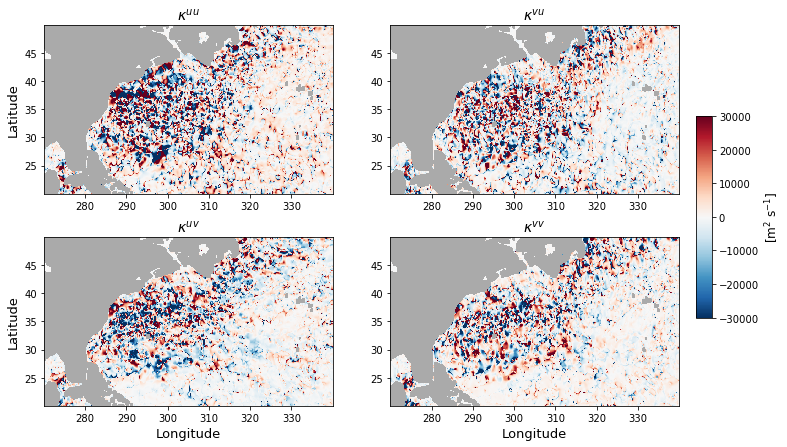

In [67]:
fig, axes = plt.subplots(figsize=(12,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(sig=0)[:,:,0,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(sig=0)[:,:,0,1].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(sig=0)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(sig=0)[:,:,1,1].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)

axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                     ticks=[-30000,-20000,-10000,0,10000,20000,30000]
                    )
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,
                    'Figures/Kappas_5Dave-delta_isig%02d_2008-Jan-03_Hann-ker%02d.pdf' 
                    % (l,nk)))

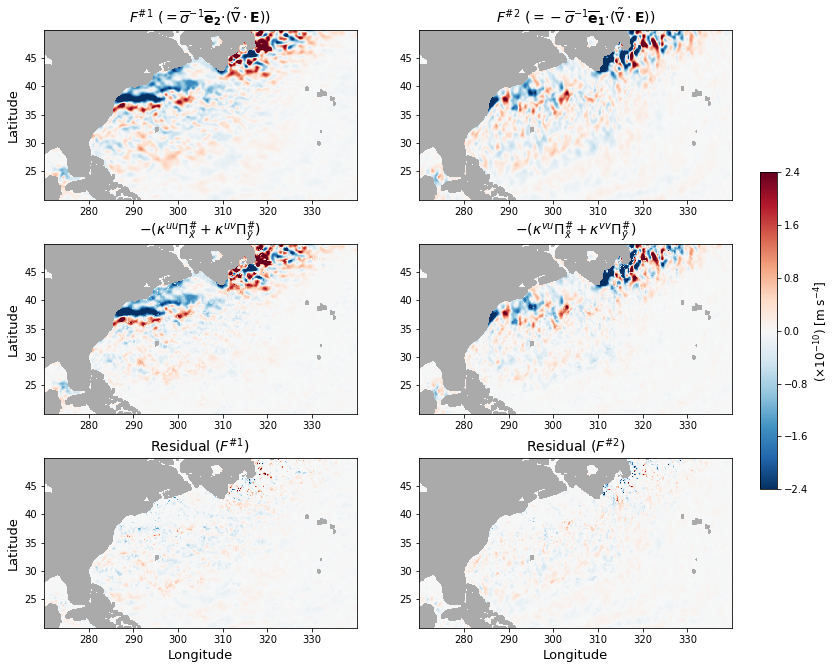

In [68]:
fig, axes = plt.subplots(figsize=(13,11), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           uPV.sel(YC=slice(yNstart+5,yend),XC=slice(xlim[0],xlim[1]))*1e10, 
                           vmin=-2.4, vmax=2.4, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           vPV.sel(YC=slice(yNstart+5,yend),XC=slice(xlim[0],xlim[1]))*1e10, 
                           vmin=-2.4, vmax=2.4, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -(K.isel(sig=0)[:,:,0,0]*PVx_sm.sel(YC=slice(yNstart+5,yend))
                             + K.isel(sig=0)[:,:,1,0]*PVy_sm.sel(YC=slice(yNstart+5,yend))
                            )*1e10, 
                           vmin=-2.4, vmax=2.4, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -(K.isel(sig=0)[:,:,0,1]*PVx_sm.sel(YC=slice(yNstart+5,yend))
                             + K.isel(sig=0)[:,:,1,1]*PVy_sm.sel(YC=slice(yNstart+5,yend))
                            )*1e10, 
                           vmin=-2.4, vmax=2.4, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           (uPV.sel(YC=slice(yNstart+5,yend))
                            +(K.isel(sig=0)[:,:,0,0]*PVx_sm.sel(YC=slice(yNstart+5,yend))
                              + K.isel(sig=0)[:,:,1,0]*PVy_sm.sel(YC=slice(yNstart+5,yend)))
                           )*1e10, 
                           vmin=-2.4, vmax=2.4, cmap='RdBu_r', 
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           (vPV.sel(YC=slice(yNstart+5,yend)) 
                            +(K.isel(sig=0)[:,:,0,1]*PVx_sm.sel(YC=slice(yNstart+5,yend))
                              + K.isel(sig=0)[:,:,1,1]*PVy_sm.sel(YC=slice(yNstart+5,yend)))
                           )*1e10,
                           vmin=-2.4, vmax=2.4, cmap='RdBu_r',
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)

axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)



axes[0,0].set_title(r"$F^{\#1}$ $(= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[0,1].set_title(r"$F^{\#2}$ $(= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\Pi^\#_\tilde{x} + \kappa^{uv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\Pi^\#_\tilde{x} + \kappa^{vv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[2,0].set_title(r"Residual ($F^{\#1}$)", 
                    fontsize=14)
axes[2,1].set_title(r"Residual ($F^{\#2}$)", 
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.89, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                    ticks=[-2.4,-1.6,-.8,0.,.8,1.6,2.4])
cbar0.set_label(r"$(\times 10^{-10})$ [m s$^{-4}$]", fontsize=12)

plt.savefig(op.join(ddir,
            'Figures/PV_param_5Dave_isig%02d_2008-Jan-03_Hann-ker%02d.pdf' 
                    % (l,nk)))

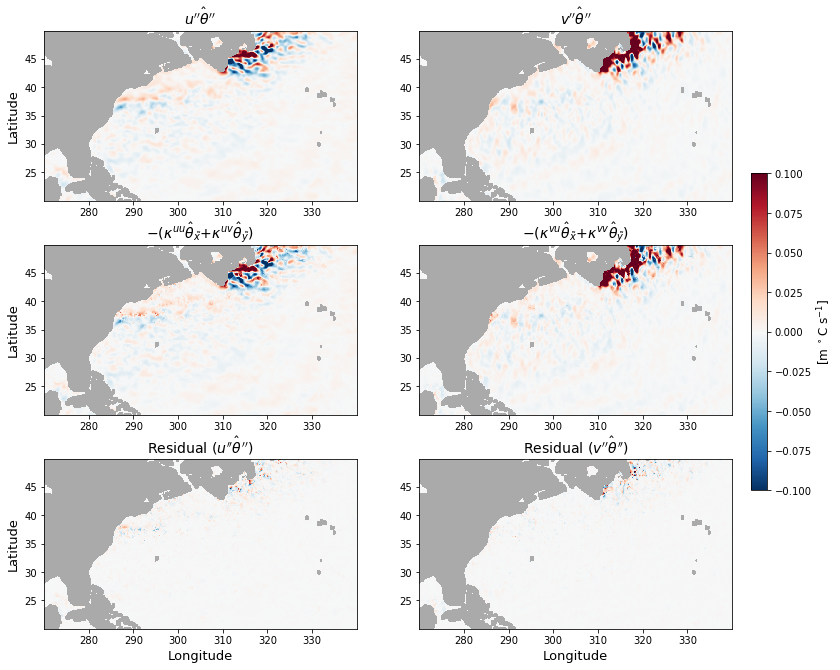

In [71]:
fig, axes = plt.subplots(figsize=(13,11), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           ut.sel(YC=slice(yNstart+5,yend),XC=slice(xlim[0],xlim[1])), 
                           vmin=-1.e-1, vmax=1.e-1, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YG.sel(YG=slice(yNstart+5,yend)), 
                           vt.sel(YC=slice(yNstart+5,yend),XC=slice(xlim[0],xlim[1])), 
                           vmin=-1.e-1, vmax=1.e-1, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -(K.isel(sig=0)[:,:,0,0]*tx_sm.sel(YC=slice(yNstart+5,yend))
                             + K.isel(sig=0)[:,:,1,0]*ty_sm.sel(YC=slice(yNstart+5,yend))), 
                           vmin=-1.e-1, vmax=1.e-1, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -(K.isel(sig=0)[:,:,0,1]*tx_sm.sel(YC=slice(yNstart+5,yend))
                             + K.isel(sig=0)[:,:,1,1]*ty_sm.sel(YC=slice(yNstart+5,yend))), 
                           vmin=-1.e-1, vmax=1.e-1, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           ut.sel(YC=slice(yNstart+5,yend))
                           +(K.isel(sig=0)[:,:,0,0]*tx_sm.sel(YC=slice(yNstart+5,yend))
                             + K.isel(sig=0)[:,:,1,0]*ty_sm.sel(YC=slice(yNstart+5,yend))), 
                           vmin=-1.e-1, vmax=1.e-1, cmap='RdBu_r', 
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           vt.sel(YC=slice(yNstart+5,yend)) 
                           +(K.isel(sig=0)[:,:,0,1]*tx_sm.sel(YC=slice(yNstart+5,yend))
                             + K.isel(sig=0)[:,:,1,1]*ty_sm.sel(YC=slice(yNstart+5,yend))),
                           vmin=-1.e-1, vmax=1.e-1, cmap='RdBu_r',
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)

axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\hat{u''\theta''}$", 
                    fontsize=14)
axes[0,1].set_title(r"$\hat{v''\theta''}$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{\theta}_\tilde{x}$"
                    + r"$+ \kappa^{uv}\hat{\theta}_\tilde{y})$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{\theta}_\tilde{x}$"
                     + r"$+ \kappa^{vv}\hat{\theta}_\tilde{y})$", 
                    fontsize=14)
axes[2,0].set_title(r"Residual ($\hat{u''\theta''}$)", 
                    fontsize=14)
axes[2,1].set_title(r"Residual ($\hat{v''\theta''}$)", 
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0,
                    ticks=[-.1,-.075,-.05,-.025,0.,.025,.05,.075,.1])
cbar0.set_label(r"[m $^\circ$C s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,
            'Figures/Theta_param_5Dave-delta_isig%02d_2008-Jan-03_Hann-ker%02d.pdf' 
                    % (l,nk)))

In [65]:
rx = (np.nanmedian(np.abs(uppspphat.isel(sig=l).sel(YC=slice(yNstart+5,yend))))
      * np.nanmedian(np.abs(-(K.isel(sig=0)[:,:,0,0]*sx.sel(YC=slice(yNstart+5,yend))
                              + K.isel(sig=0)[:,:,1,0]*sy.sel(YC=slice(yNstart+5,yend))))
                    )**-1)
ry = (np.nanmedian(np.abs(vppspphat.isel(sig=l).sel(YG=slice(yNstart+5,yend))))
      * np.nanmedian(np.abs(-(K.isel(sig=0)[:,:,0,1]*sx.sel(YC=slice(yNstart+5,yend))
                              + K.isel(sig=0)[:,:,1,1]*sy.sel(YC=slice(yNstart+5,yend))))
                    )**-1)
print(rx,ry)

2.672617789849822 2.754850892209865


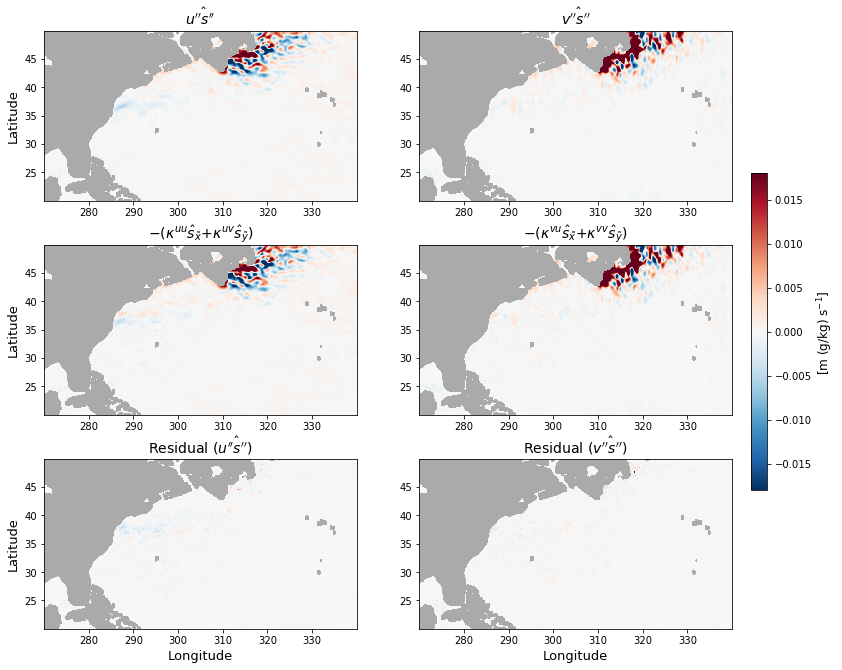

In [72]:
fig, axes = plt.subplots(figsize=(13,11), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           us.sel(YC=slice(yNstart+5,yend),XC=slice(xlim[0],xlim[1])), 
                           vmin=-1.8e-2, vmax=1.8e-2, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           vs.sel(YC=slice(yNstart+5,yend),XC=slice(xlim[0],xlim[1])), 
                           vmin=-1.8e-2, vmax=1.8e-2, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -1.*(K.isel(sig=0)[:,:,0,0]*sx_sm.sel(YC=slice(yNstart+5,yend))
                                + K.isel(sig=0)[:,:,1,0]*sy_sm.sel(YC=slice(yNstart+5,yend))),
                           vmin=-1.8e-2, vmax=1.8e-2, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -1.*(K.isel(sig=0)[:,:,0,1]*sx_sm.sel(YC=slice(yNstart+5,yend))
                                + K.isel(sig=0)[:,:,1,1]*sy_sm.sel(YC=slice(yNstart+5,yend))),
                           vmin=-1.8e-2, vmax=1.8e-2, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           us.sel(YC=slice(yNstart+5,yend))
                           + 1.*(K.isel(sig=0)[:,:,0,0]*sx_sm.sel(YC=slice(yNstart+5,yend))
                                 + K.isel(sig=0)[:,:,1,0]*sy_sm.sel(YC=slice(yNstart+5,yend))),
                           vmin=-1.8e-2, vmax=1.8e-2, cmap='RdBu_r', 
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), 
                           dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           vs.sel(YC=slice(yNstart+5,yend)) 
                           + 1.*(K.isel(sig=0)[:,:,0,1]*sx_sm.sel(YC=slice(yNstart+5,yend))
                                 + K.isel(sig=0)[:,:,1,1]*sy_sm.sel(YC=slice(yNstart+5,yend))),
                           vmin=-1.8e-2, vmax=1.8e-2, cmap='RdBu_r',
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)

axes[0,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                     np.ma.masked_array(maskK, ~maskK),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$\hat{u''s''}$",
                    fontsize=14)
axes[0,1].set_title(r"$\hat{v''s''}$",
                    fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{s}_\tilde{x}$"
                    + r"$+ \kappa^{uv}\hat{s}_\tilde{y})$",
                    fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{s}_\tilde{x}$"
                    + r"$+ \kappa^{vv}\hat{s}_\tilde{y})$",
                    fontsize=14)
axes[2,0].set_title(r"Residual ($\hat{u''s''}$)",
                    fontsize=14)
axes[2,1].set_title(r"Residual ($\hat{v''s''}$)",
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m (g/kg) s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,
            'Figures/Salt_param_5Dave-delta_isig%02d_2008-Jan-03_Hann-ker%02d.pdf'
                    % (l,nk)))

# See if the eddy fluxes are actually down gradient.

In [74]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


ang = xr.DataArray(np.ones((len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),
                            len(dsz.XC),1,3))*np.nan,
                   dims=['YC','XC','sig','var'],
                   coords={'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data,
                           'XC':dsz.XC.data,'sig':np.array([dsz.sig.isel(sig=l)])}
                  )

for j in range(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)))):
    if j % 40 == 0:
        print('j =', j)
    for i in range(len(dsz.XC)):
##########################
        dataF = np.array([[uPV.isel(YC=j,XC=i)],   
                          [vPV.isel(YC=j,XC=i)]])
        F = dataF

        dataG = np.array([[-PVx_sm.isel(YC=j,XC=i),   
                           -PVy_sm.isel(YC=j,XC=i)]])
        G = dataG
        
        if ~(np.isnan(F).any() or np.isnan(G).any()):
            ang[j,i,0,0] = angle_between(G,F)[0][0]
##########################            
        dataF = np.array([[ut.isel(YC=j,XC=i)],   
                          [vt.isel(YC=j,XC=i)]])
        F = dataF

        dataG = np.array([[-tx_sm.isel(YC=j,XC=i),   
                           -ty_sm.isel(YC=j,XC=i)]])
        G = dataG
        
        if ~(np.isnan(F).any() or np.isnan(G).any()):
            ang[j,i,0,1] = angle_between(G,F)[0][0]
##########################
        dataF = np.array([[us.isel(YC=j,XC=i)],   
                          [vs.isel(YC=j,XC=i)]])
        F = dataF

        dataG = np.array([[-sx_sm.isel(YC=j,XC=i),   
                           -sy_sm.isel(YC=j,XC=i)]])
        G = dataG
        
        if ~(np.isnan(F).any() or np.isnan(G).any()):
            ang[j,i,0,2] = angle_between(G,F)[0][0]


itime = 7886160
ang.to_dataset(name='radian').to_netcdf(op.join(ddir,
                                    '5Dave/run%4d/Angle_5Dave-delta_Hann-ker%02d_isig%02d_%010d.nc' 
                                         % (year,nk,l,itime)), mode='w')
ang

j = 0
j = 40
j = 80
j = 120
j = 160
j = 200
j = 240
j = 280
j = 320
j = 360


<xarray.DataArray (YC: 361, XC: 1000, sig: 1, var: 3)>
array([[[[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        ...,

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]]],


       [[[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        ...,

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]]],


       [[[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        ...,

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]],

        [[       nan,        nan,        nan]]],


       ...,


       [[[1.48414202, 1.55905922, 1.45846734]],

        [[1.32391091, 1.07367686, 0.94387704]],

        [[1.43189095, 1.31130543, 1.2020748 ]],

        ...,

        [[0.02112882, 0.93128899, 0.57732803]],

        [[0.27420083, 1.23688638, 0.84642005]],

        [[0.22438914, 1.22645619, 0.99785624]]],


       [[[1.27741528, 1.47097203, 1.22483073]],

        [[1.1449971 , 1.08037065, 0.8558867 ]],

        [[1.26616532, 1.32120416, 1.15687096]],

        ...,

        [[0.09117595, 0.93735902, 0.48016042]],

        [[0.36039295, 1.23776027, 0.66959555]],

        [[0.07646224, 1.14418906, 0.91481507]]],


       [[[1.10686858, 1.38634969, 0.98637522]],

        [[1.03965921, 1.15635603, 0.8285504 ]],

        [[1.15853525, 1.3815784 , 1.16973609]],

        ...,

        [[0.02718097, 0.86136513, 0.43141715]],

        [[0.24806107, 1.11020698, 0.52386945]],

        [[0.05109823, 1.07468826, 0.86004618]]]])
Coordinates:
  * YC       (YC) float64 20.0 20.08 20.17 20.25 ... 49.75 49.83 49.92 50.0
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 26.53
Dimensions without coordinates: var

In [75]:
ang = xr.open_dataset(op.join(ddir,'5Dave/run%4d/Angle_5Dave-delta_Hann-ker%02d_isig%02d_%010d.nc' 
                              % (year,nk,l,itime))).radian
ang

<xarray.DataArray 'radian' (YC: 361, XC: 1000, sig: 1, var: 3)>
[1083000 values with dtype=float64]
Coordinates:
  * YC       (YC) float64 20.0 20.08 20.17 20.25 ... 49.75 49.83 49.92 50.0
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 26.53
Dimensions without coordinates: var

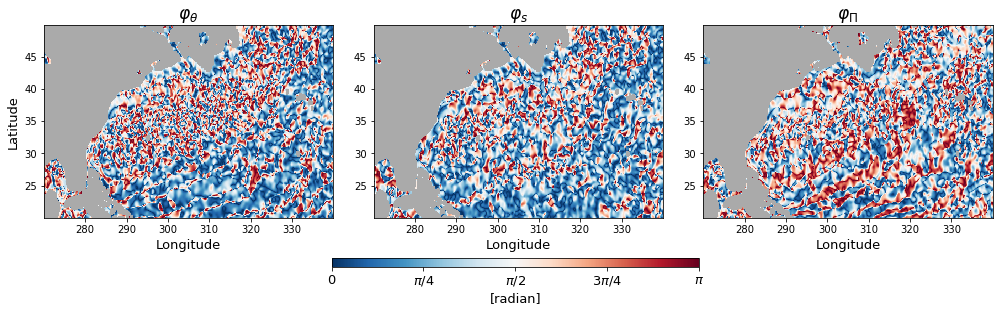

In [77]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(17,4), nrows=1, ncols=3)
# fig.set_tight_layout(True)

ax1.pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)),
               ang.sel(YC=slice(yNstart+5,yend),
                       XC=slice(xlim[0],xlim[1])).isel(sig=0)[:,:,1]*180/np.pi,
               vmax=180, vmin=0, cmap='RdBu_r', rasterized=True)
ax1.set_title(r"$\varphi_\theta$", fontsize=17)

ax2.pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)),
               ang.sel(YC=slice(yNstart+5,yend),
                       XC=slice(xlim[0],xlim[1])).isel(sig=0)[:,:,-1]*180/np.pi,
               vmax=180, vmin=0, cmap='RdBu_r', rasterized=True)
ax2.set_title(r"$\varphi_s$", fontsize=17)

im3 = ax3.pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)),
                     ang.sel(YC=slice(yNstart+5,yend),
                             XC=slice(xlim[0],xlim[1])).isel(sig=0)[:,:,0]*180/np.pi,
                     vmax=180, vmin=0, cmap='RdBu_r', rasterized=True)
ax3.set_title(r"$\varphi_\Pi$", fontsize=17)

ax1.pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
               np.ma.masked_array(maskK, ~maskK),
               vmin=0, vmax=3, cmap='binary', rasterized=True)
ax2.pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
               np.ma.masked_array(maskK, ~maskK),
               vmin=0, vmax=3, cmap='binary', rasterized=True)
ax3.pcolormesh(dsz.XC.sel(XC=slice(xlim[0],xlim[1])), dsz.YC.sel(YC=slice(yNstart+5,yend)), 
               np.ma.masked_array(maskK, ~maskK), 
               vmin=0, vmax=3, cmap='binary', rasterized=True)


ax1.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax3.set_xlabel(r"Longitude", fontsize=13)

fig.subplots_adjust(top=0.88, bottom=0.21, wspace=.14) 
cbax = fig.add_axes([0.36, 0.04, 0.3, 0.03])
cbar = fig.colorbar(im3, ticks=[0, 45, 90, 135, 180], cax=cbax, orientation='horizontal')
cbar.ax.set_xticklabels([r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize=13)
cbar.set_label(r"[radian]", fontsize=13)
# cbar.ax.tick_params(labelsize=12)

plt.savefig(op.join(ddir,'Figures/Angle_5Dave-delta_isig%02d_Hann-ker%02d_2008-Jan-03.pdf' 
                    % (l,nk)))